### Time Series Workshop 
# 2. Air Pollutants &#x1F525;: Analysis

In this notebook, we will analyse time series data on pollutant concentration.

## Dataset synopsis

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

- The dataset contains hourly recordings of air pollutants concentration in an Italian city.

- For sake of simplicity, we will limit our work to the variable **relative humidity** (humidity) and measured **carbon monoxide concentration** (co_sensor) in mg/m^3.

- This dataset is a bit challenging because
  - Timestamps are not equidistant 
  - Entire days of recordings are missing, probably due to data collection failure. 
  - There are also outliers wherever the sensors did not manage to obtain a measurement of humidity or CO concentration.

In [1]:
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from pathlib import Path
from timeseries.data import load_air_quality

DATA_DIR = Path("..") / Path("data")


## Load and process data

In [2]:
FILE_PATH = DATA_DIR / "air_quality.csv"

df_in = load_air_quality(FILE_PATH)
df_in.head()


,co_true,co_sensor,nmhc_true,c6h6_true,nmhc_sensor,nox_true,nox_sensor,no2_true,no2_sensor,o3_sensor,t,humidity,ah
date_time,,,,,,,,,,,,,
2004-04-04 00:00:00,-200.0,1224.0,-200.0,7.8,892.0,-200.0,884.0,-200.0,1580.0,923.0,16.7,56.5,1.0634
2004-04-04 01:00:00,-200.0,1215.0,-200.0,6.7,843.0,-200.0,929.0,-200.0,1551.0,862.0,15.9,59.2,1.0635
2004-04-04 02:00:00,-200.0,1115.0,-200.0,5.4,782.0,-200.0,980.0,-200.0,1500.0,752.0,15.2,62.4,1.0726
2004-04-04 03:00:00,-200.0,1124.0,-200.0,5.6,793.0,-200.0,965.0,-200.0,1521.0,791.0,14.7,65.0,1.0766
2004-04-04 04:00:00,-200.0,1028.0,-200.0,3.5,682.0,-200.0,1090.0,-200.0,1448.0,697.0,14.3,65.3,1.0594


In [3]:
variables = ["co_sensor", "humidity"]
df = df_in[variables].copy()
df.head()

,co_sensor,humidity
date_time,,
2004-04-04 00:00:00,1224.0,56.5
2004-04-04 01:00:00,1215.0,59.2
2004-04-04 02:00:00,1115.0,62.4
2004-04-04 03:00:00,1124.0,65.0
2004-04-04 04:00:00,1028.0,65.3


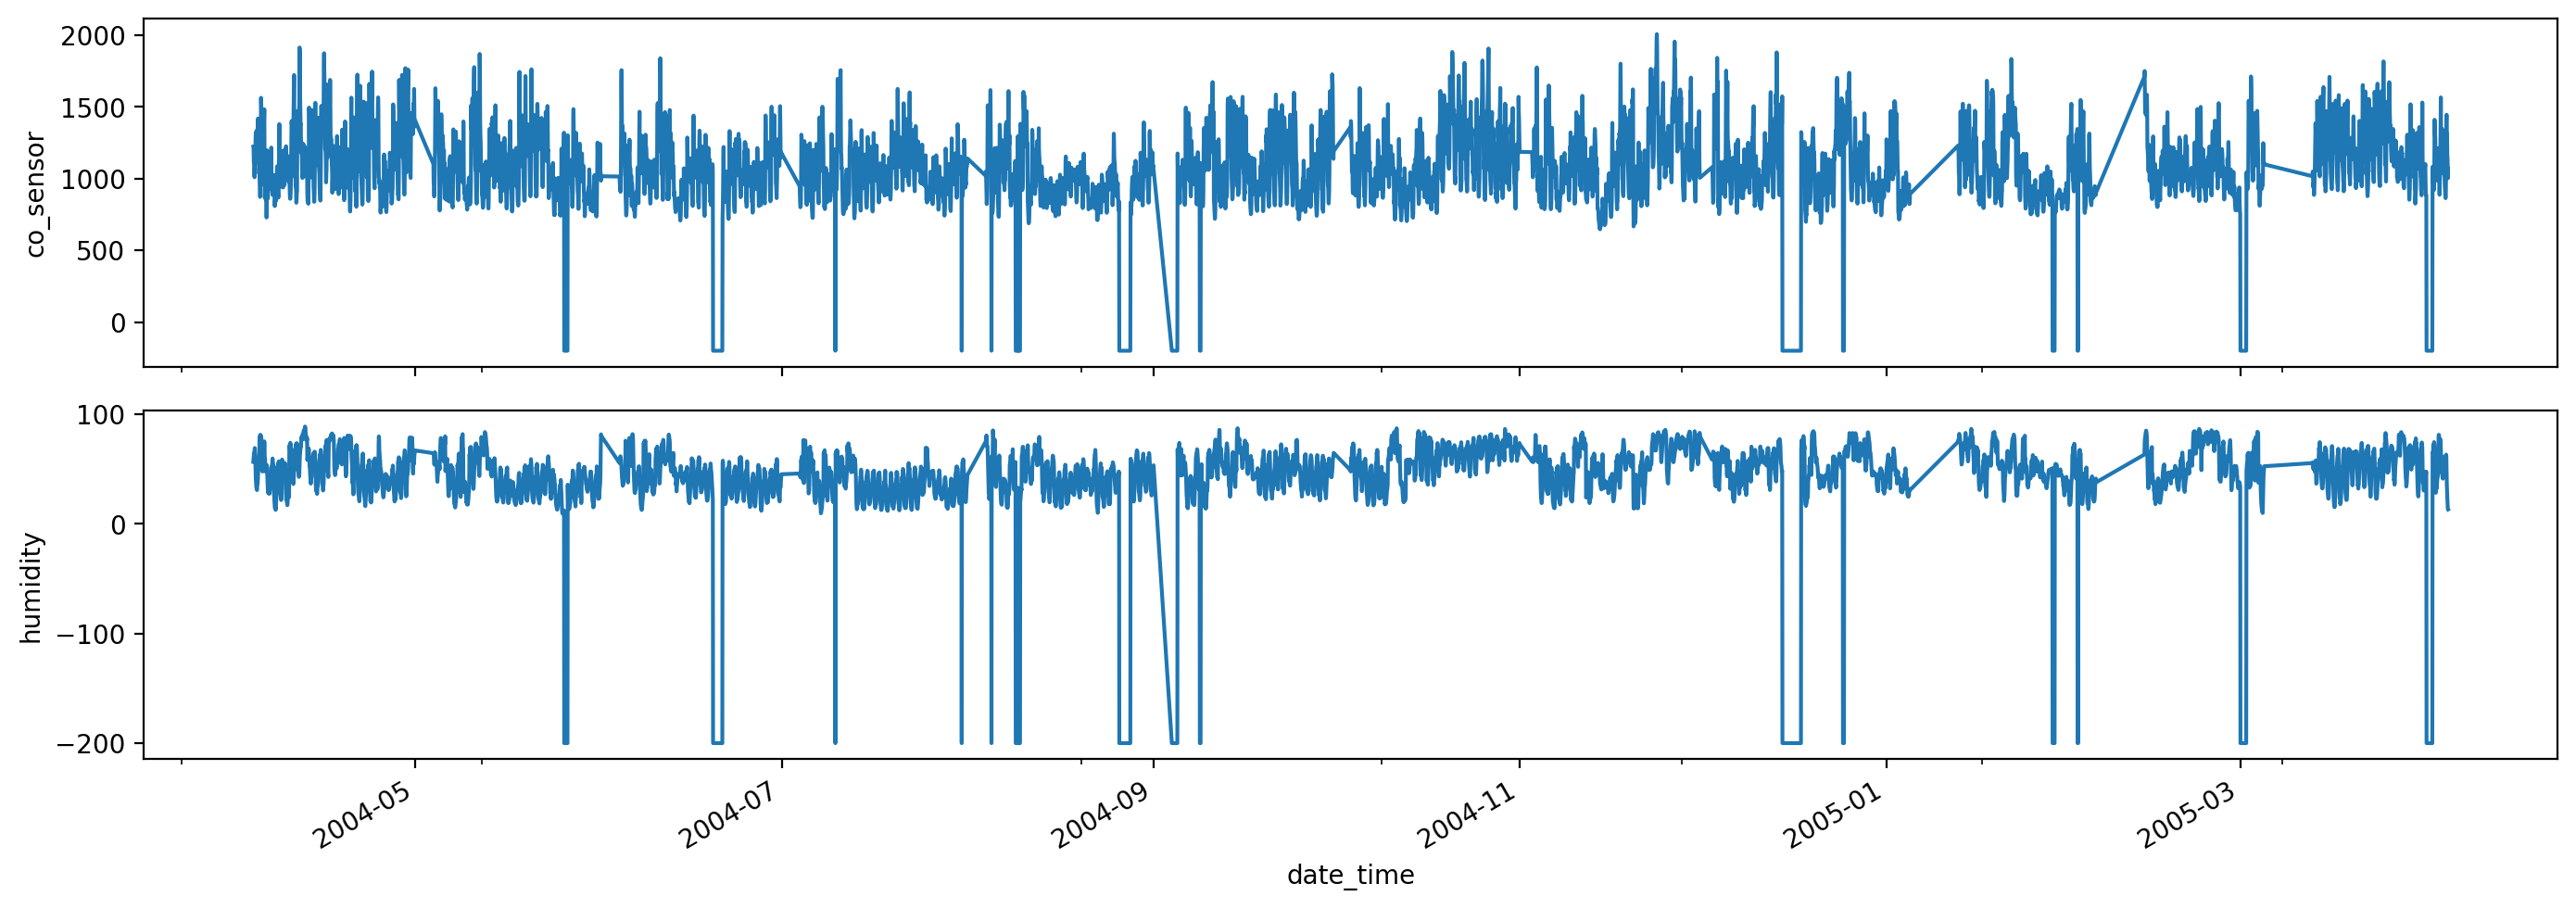

In [4]:
_, axs = plt.subplots(2, 1, figsize=(14, 5), sharex=True)
for var, ax in zip(variables, axs):
    df[var].plot(ax=ax)
    ax.set_ylabel(var)
plt.tight_layout()


## Preprocessing
- There are records missing: pandas plot interpolates linearly between available values.
- Some values are negative, most likely measurement errors, as concentration or humidity level can't be negative.

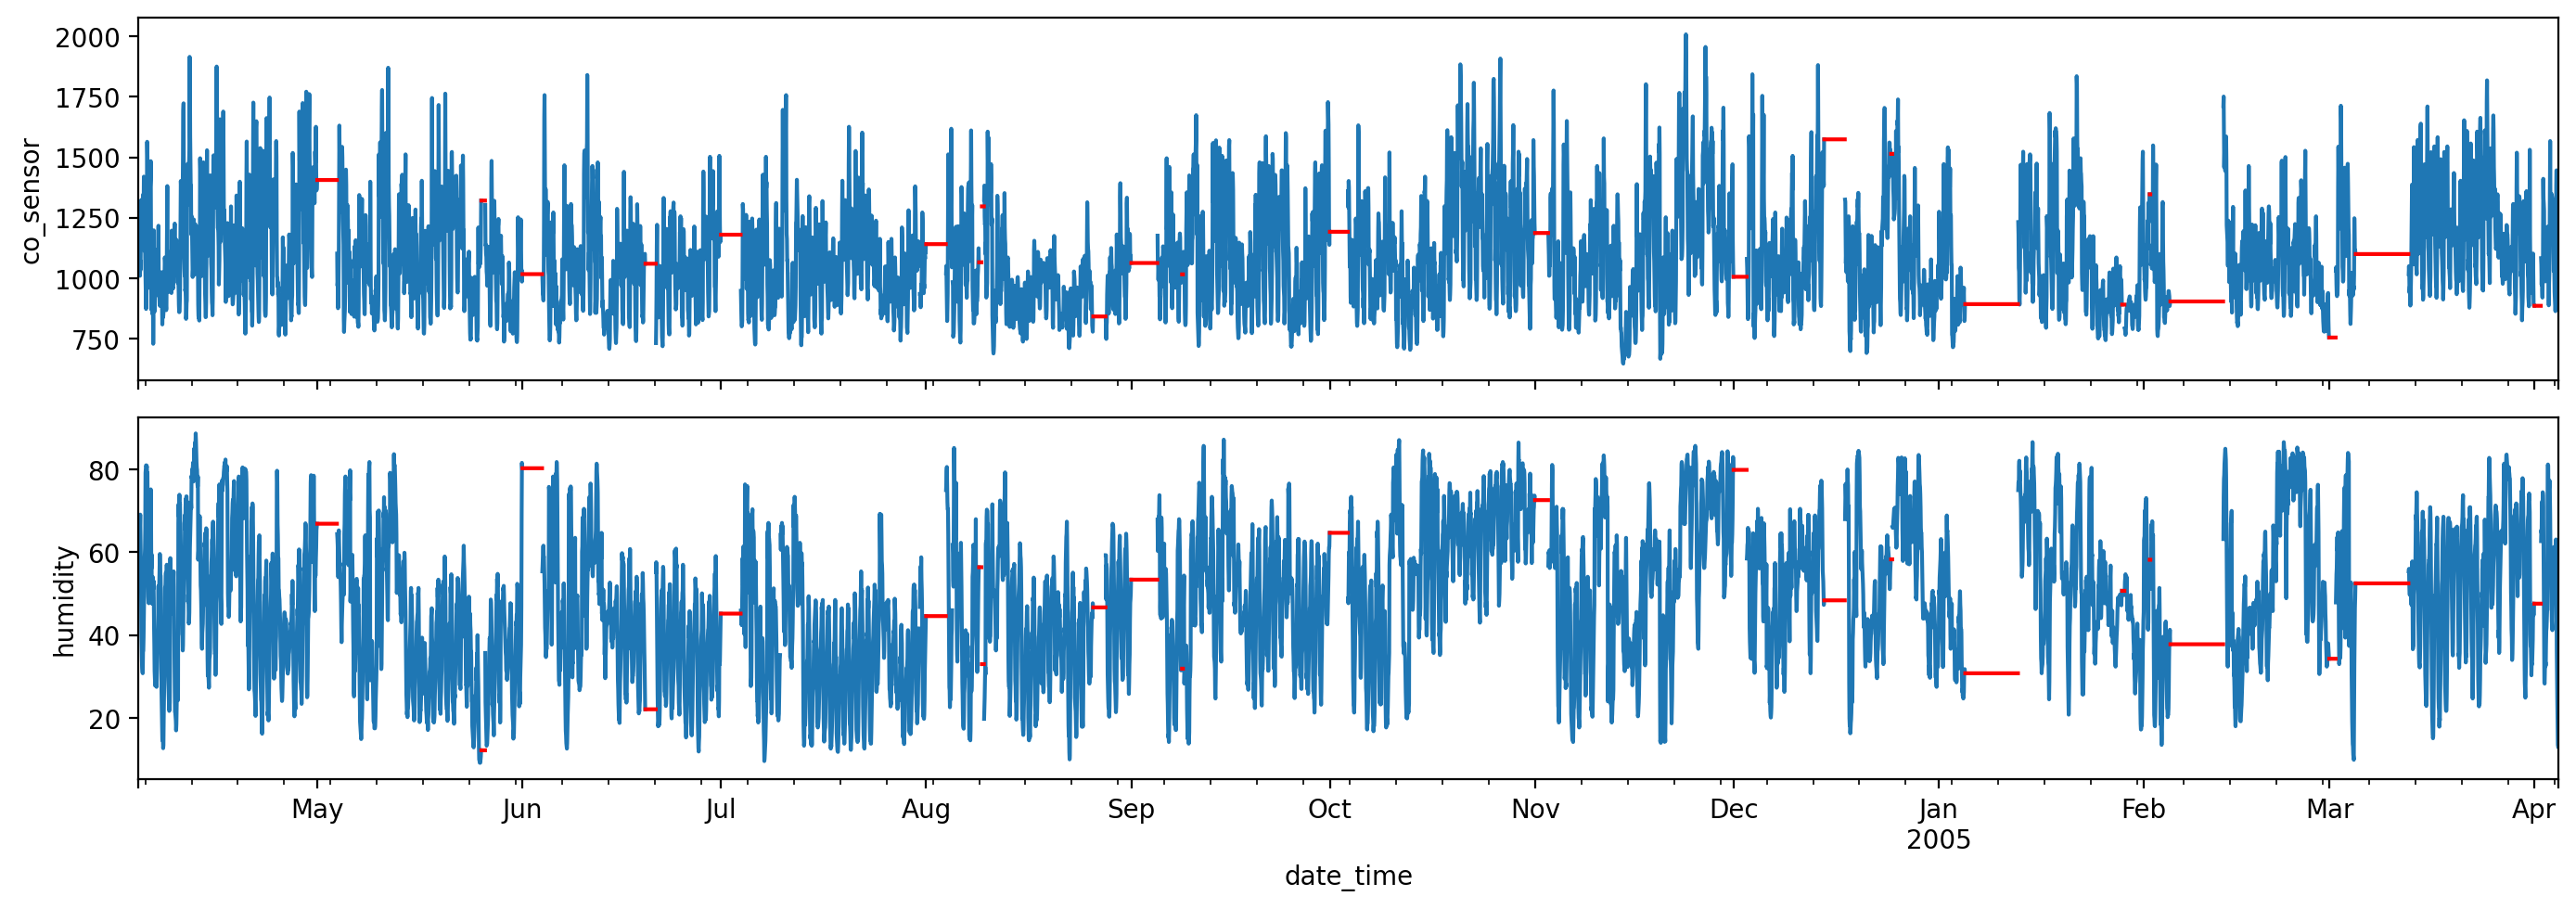

In [5]:
# Remove faulty values:
for var in variables:
    df = df[df[var] >= 0]

df_ = df.asfreq("1H")

# Apply the forward fill method.
df_imputed = df_.fillna(method="ffill")

_, axs = plt.subplots(2, 1, figsize=(14, 5), sharex=True)
for var, ax in zip(variables, axs):
    df_[var].plot(ax=ax, marker="none")
    df_imputed[df_.isnull()][var].plot(ax=ax, legend=None, color="r")
    ax.set_ylabel(var)
plt.tight_layout()

## Seasonality

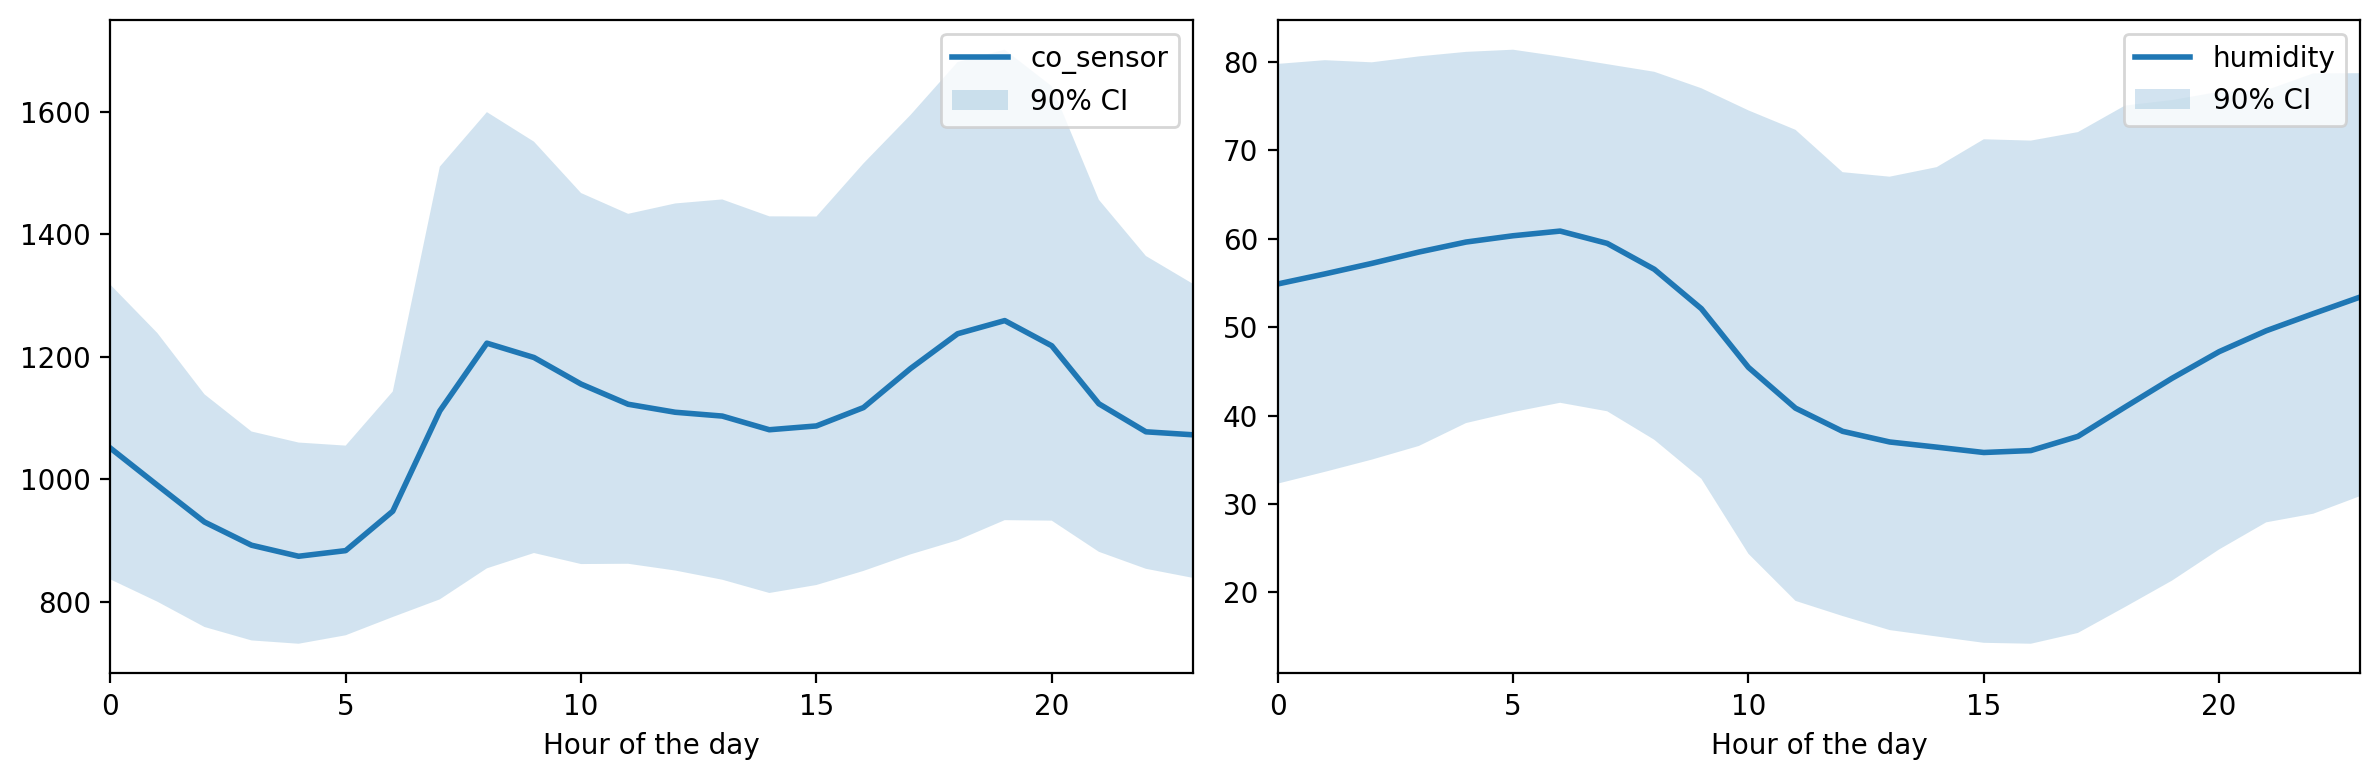

In [6]:
def q05(x):
    return x.quantile(0.05)


def q95(x):
    return x.quantile(0.95)


_, axs = plt.subplots(1, 2, figsize=(12, 4))
for var, ax in zip(variables, axs):
    df_v = df[[var]].copy()

    # Group by hour of the day and compute mean and 90% confidence interval
    df_v["hour"] = df_v.index.hour
    df_time_season = df_v.groupby("hour")[[var]].agg(["mean", q05, q95])

    # Plot mean values
    ax.plot(df_time_season[var]["mean"], label=var, linewidth=2)

    # Plot confidence intervals
    ax.fill_between(
        df_time_season.index,
        df_time_season[var]["q05"],
        df_time_season[var]["q95"],
        alpha=0.2,
        label="90% CI",
    )

    ax.set_xlabel("Hour of the day")
    ax.set_xlim((0, 23))
    ax.legend()
plt.tight_layout()

Indeed, there's some clear seasonality of
- Carbon monoxide concentration during rush-hours
- Humidity (due to the daily temperature cycle)